In [1]:
# Created by Matt Davison 03/01/2026
# Tests the cancellation performance across frequency of the HaptiCoupler system, communicating with it via USB Serial.

import serial
import numpy as np
import sounddevice as sd
import scipy.signal as signal
import time
import matplotlib.pyplot as plt
import scienceplots

sampling_rate = 44100
freq_min_hz = 10
freq_max_hz = 20000
sweep_time_s = 5
usb_serial_name = '/dev/tty.usbmodem167058301'

In [2]:
def generate_sweep(fs, duration, f_start, f_end):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    sweep = signal.chirp(t, f0=f_start, f1=f_end, t1=duration, method='logarithmic')
    return t, sweep

def measure_system_response(fs, sweep_signal, input_gain=0.1):
    
    sweep_signal = sweep_signal * input_gain

    print("Playing and recording")
    recording = sd.playrec(sweep_signal, samplerate=fs, channels=2, dtype='float64')
    sd.wait()
    print("Done recording")

    return recording[:, 0], recording[:, 1]




print(sd.query_devices())

print("Generating sweep")
t, sweep_sig = generate_sweep(sampling_rate, sweep_time_s, freq_min_hz, freq_max_hz)

#Open USB serial connection to HaptiCoupler
ser = serial.Serial(usb_serial_name)
print(ser.name) #Print the name of the opened serial port

#Set LPFs to cut off at 20kHz
ser.write(b'lpi 20000\n')
ser.write(b'lpo 20000\n')

#Ensure that the HaptiCoupler is in Debug mode (raw current values returned)
ser.write(b'debug\n')
time.sleep(0.1)
print("Baseline sweep in debug mode")

baseline_current, baseline_voltage = measure_system_response(sampling_rate, sweep_sig)



#Ensure that the HaptiCoupler is in Normal mode (cancellation being applied)
ser.write(b'normal\n')
time.sleep(0.1)
print("Cancellation sweep in normal mode")

cancelled_l, cancelled_r = measure_system_response(sampling_rate, sweep_sig)



#Close the USB serial connection with the HaptiCoupler
ser.close()

   0 C27F390, Core Audio (0 in, 2 out)
>  1 Teensy MIDI_Audio, Core Audio (2 in, 0 out)
<  2 Teensy MIDI_Audio, Core Audio (0 in, 2 out)
   3 MacBook Pro Microphone, Core Audio (1 in, 0 out)
   4 MacBook Pro Speakers, Core Audio (0 in, 2 out)
   5 Microsoft Teams Audio, Core Audio (1 in, 1 out)
   6 ZoomAudioDevice, Core Audio (2 in, 2 out)
   7 Teensy & HP, Core Audio (0 in, 0 out)
   8 Aggregate Device, Core Audio (0 in, 0 out)
   9 Teensy and Speakers, Core Audio (0 in, 2 out)
  10 teensy io combined, Core Audio (0 in, 0 out)
Generating sweep
/dev/tty.usbmodem167058301
Baseline sweep in debug mode
Playing and recording
Done recording
Cancellation sweep in normal mode
Playing and recording
Done recording


In [12]:
# Calculations

def calc_transfer_function(X_signal, Y_signal):
    X = np.fft.rfft(X_signal)
    Y    = np.fft.rfft(Y_signal)
    freq = np.fft.rfftfreq(len(Y_signal), 1/sampling_rate)
    
    X = np.where(np.abs(X) < 1e-12, 1e-12, X)
    Y = Y / X
    
    valid = (freq >= freq_min_hz) & (freq <= freq_max_hz)
    freq = freq[valid]
    Y = Y[valid]
    return Y, freq

def smooth_magnitude(freqs, magnitude, smoothing_octaves=0.2):
    smoothed = np.zeros_like(magnitude)
    for i, f in enumerate(freqs):
        if f <= 0:
            smoothed[i] = magnitude[i]
            continue
        f_low = f * 2**(-smoothing_octaves / 2)
        f_high = f * 2**(smoothing_octaves / 2)
        mask = (freqs >= f_low) & (freqs <= f_high)
        smoothed[i] = np.mean(magnitude[mask])
    return smoothed


Y_current_baseline, freq = calc_transfer_function(sweep_sig, baseline_current)
Y_smoothed = smooth_magnitude(freq, np.abs(Y_current_baseline))
Y_current_baseline = Y_smoothed * np.exp(1j * np.angle(Y_current_baseline))


Y_cancelled, freq = calc_transfer_function(sweep_sig, cancelled_l)
Y2_smoothed = smooth_magnitude(freq, np.abs(Y_cancelled))
Y_cancelled = Y2_smoothed * np.exp(1j * np.angle(Y_cancelled))



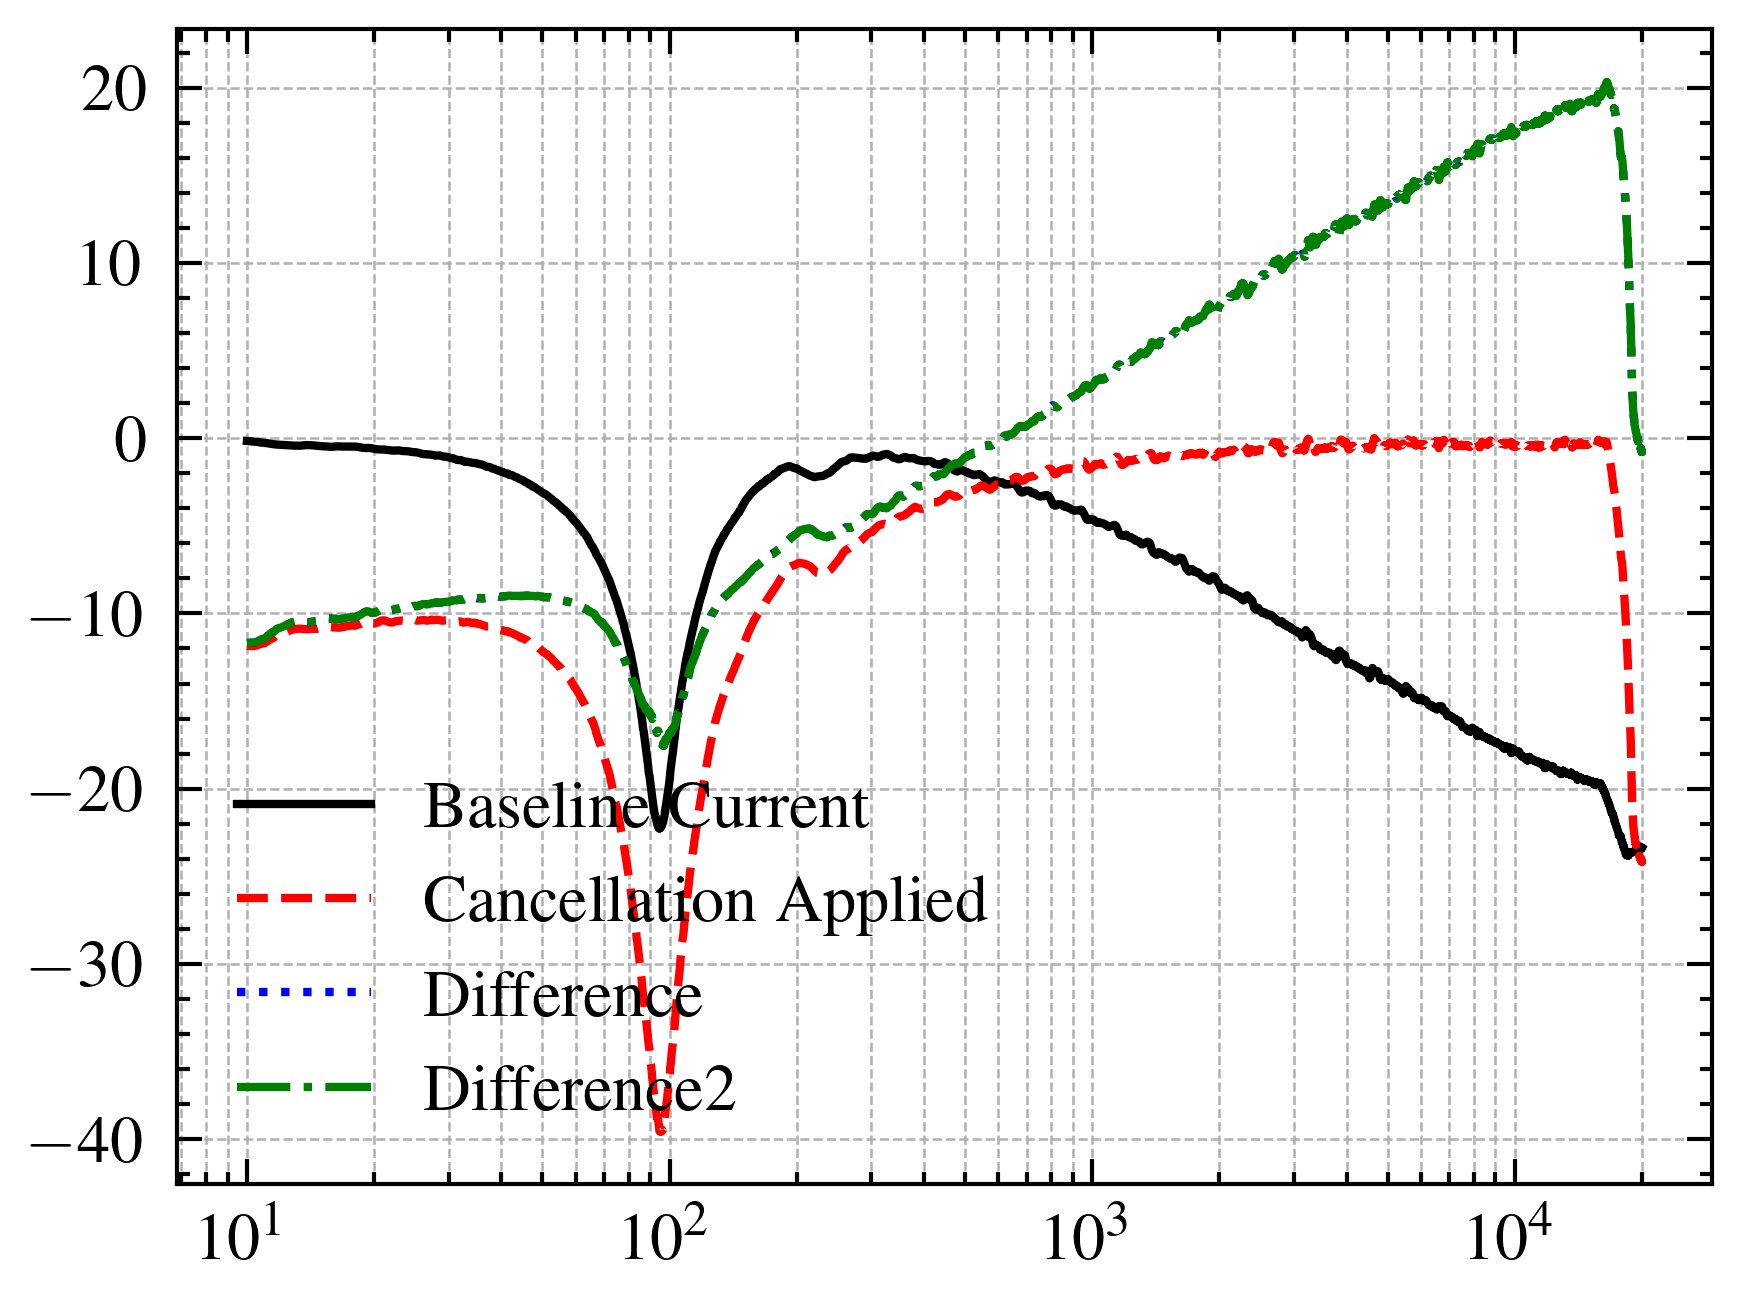

In [29]:
fig, ax = plt.subplots()

Y_abs_db = 20*np.log10(np.abs(Y_current_baseline))
Y2_abs_db = 20*np.log10(np.abs(Y_cancelled))

normaliser = max(np.max(Y_abs_db), np.max(Y2_abs_db))

Y_abs_db = Y_abs_db - normaliser
Y2_abs_db = Y2_abs_db - normaliser

ax.semilogx(freq, Y_abs_db, label="Baseline Current")
ax.semilogx(freq, Y2_abs_db, label="Cancellation Applied")
ax.semilogx(freq, 20*np.log10(np.abs(Y2)) - 20*np.log10(np.abs(Y)), label="Difference")
#ax.semilogx(freq, Y2_abs_db - Y_abs_db, label="Difference2")
ax.legend()

plt.grid(True, which='both',axis='x', linestyle='--', linewidth=0.3)
plt.grid(True, which='major',axis='y', linestyle='--', linewidth=0.3)

plt.style.use(['science','ieee'])

plt.savefig('outputs/cancellation_vs_freq.eps', format='eps')
plt.show()